# LSST CCOB ghost analysis

Develop the ghost images analysis

## TODO
- design a real image analysis to get a list of ghost spots
- update distance between 2 ghost spots to consider flux and size

## Notes
- for each optical element: 3 rotations, 3 positions
- L1, L2, L3, Filter, Detector, Beam: 6 x 6 = 36 parameters


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import timeit
import copy
import concurrent.futures 
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import batoid
import ghosts.plotter as plotter
import ghosts.simulator as simulator
import ghosts.tweak_optics as tweak_optics

from ghosts.analysis import compute_ghost_separations
from ghosts.analysis import match_ghosts, compute_reduced_distance, compute_2d_reduced_distance, find_nearest_ghost
from ghosts.analysis import make_data_frame

from ghosts.beam_configs import BEAM_CONFIG_1, BEAM_CONFIG_2, FAST_BEAM_CONFIG_1



In [3]:
from ghosts.constants import *
print(f'LSST Camera has {LSST_CAMERA_PIXEL_DENSITY_MM2:.0f} pixels per mm^2')

LSST Camera has 36000 pixels per mm^2


In [4]:
# CCOB like geometry, i.e. lenses + filters
telescope = batoid.Optic.fromYaml("../data/LSST_CCOB_r.yaml")

In [5]:
# test list of optics
assert tweak_optics.get_list_of_optics(telescope)==['L1', 'L2', 'Filter', 'L3', 'Detector'], 'Not a CCOB optical setup'

# Make refractive interfaces partially reflective
# Call on current telescope
tweak_optics.make_optics_reflective(telescope)


0

Direct path is number 28
  central impact point is (0.099495, 0.000001)
  transmission is 0.8337

Maximum expected flux is 0.8337
Maximum bin content is 668.6757


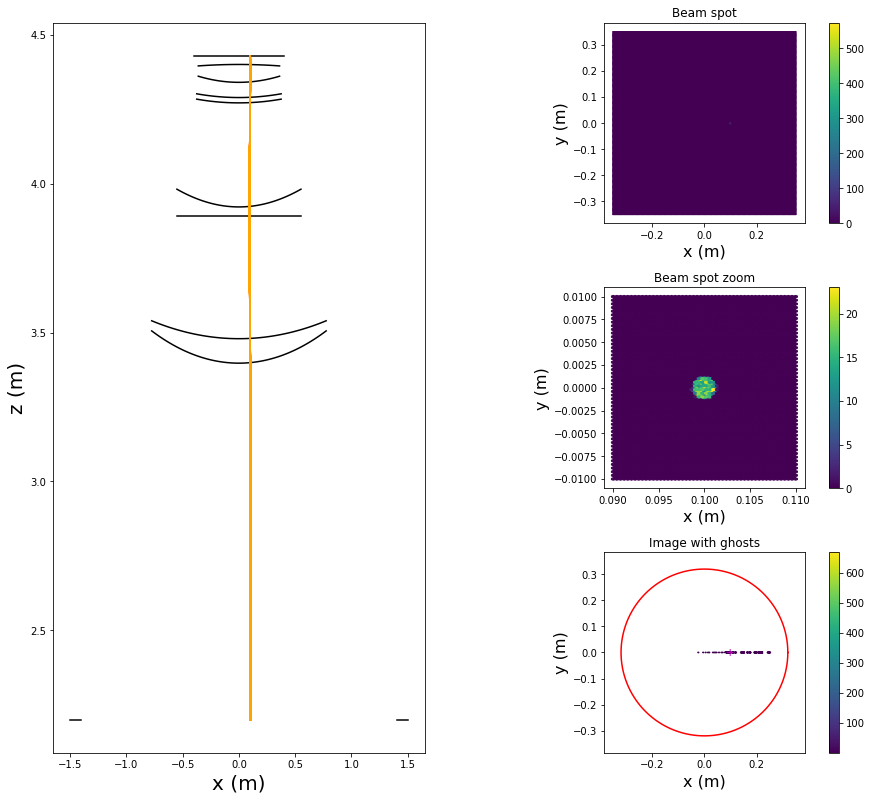

0

In [6]:
# Run simulation with standard beam config
traceFull, rForward, rReverse, rays = simulator.run_simulation(telescope, beam_config=BEAM_CONFIG_1)
simulation = [traceFull, rForward, rReverse, rays]
# Check setup
plotter.plot_setup(telescope, simulation)


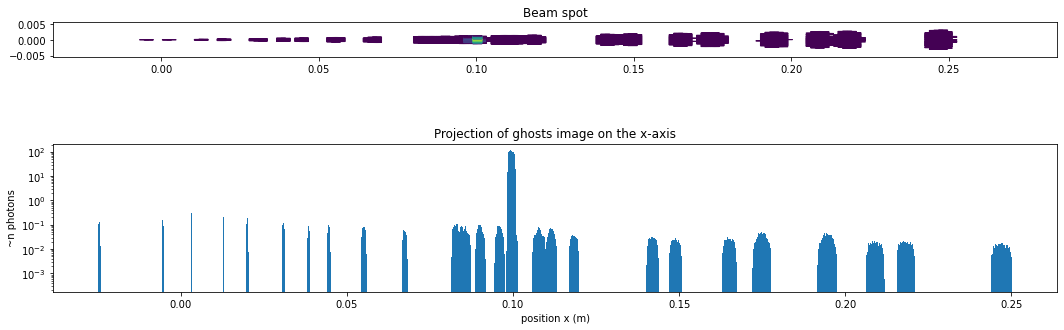

0

In [7]:
# Zoom on ghosts
plotter.plot_zoom_on_ghosts(rForward)

Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


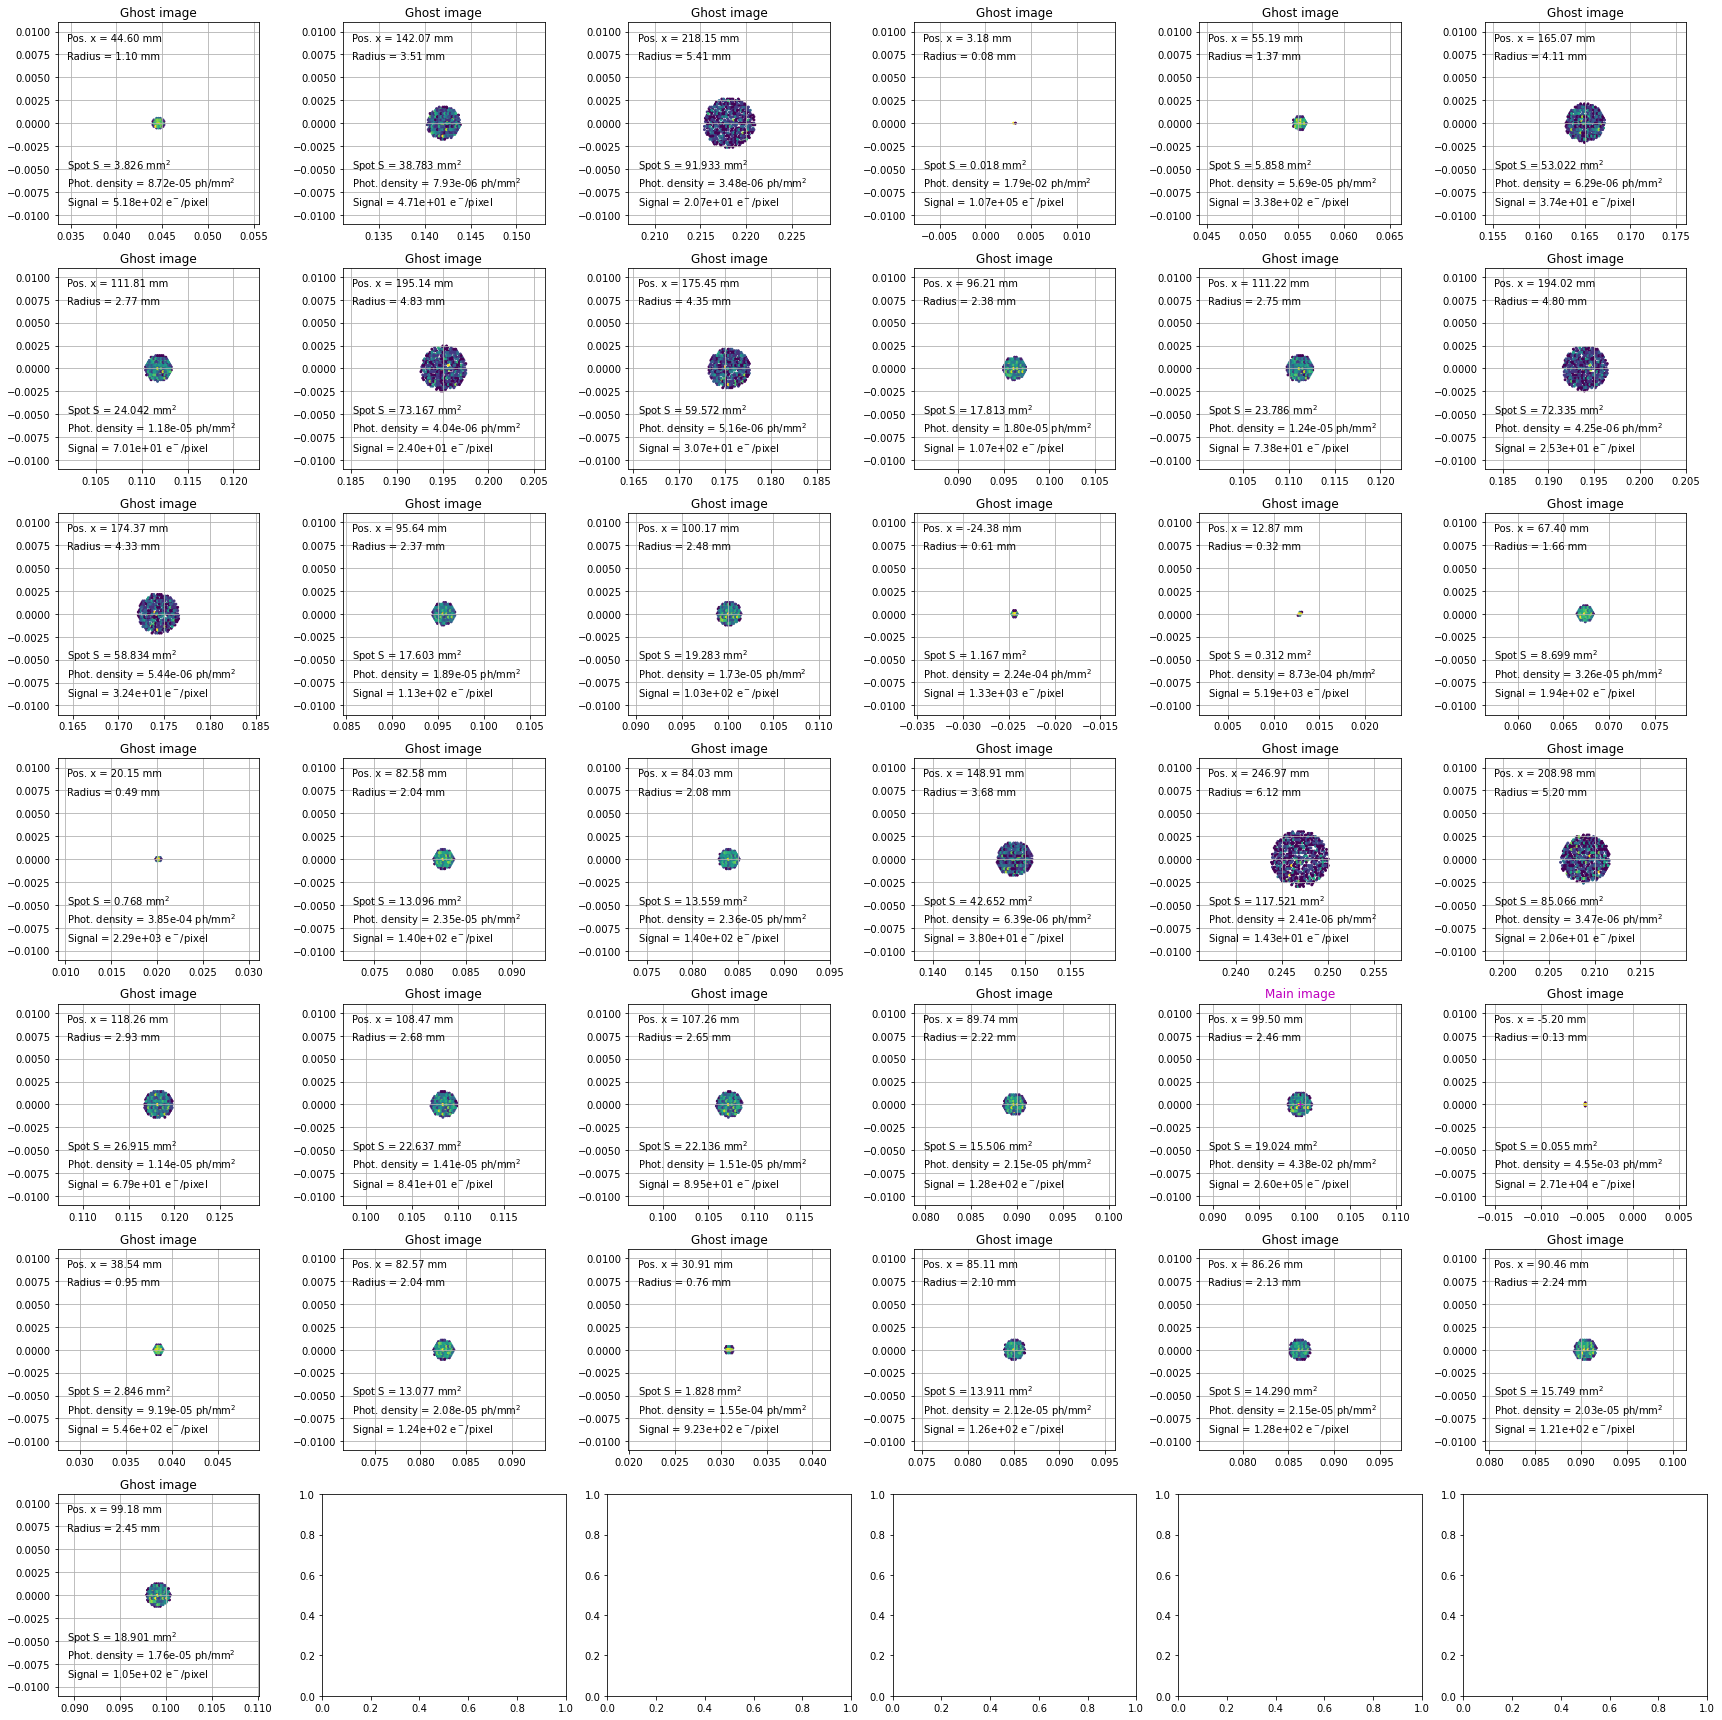

In [8]:
# make figure and fill with plots
plt.rcParams["figure.figsize"] = [24, 24]
spots_data = plotter.plot_ghosts_map(rForward)

In [9]:
data_frame_1 = make_data_frame(spots_data, BEAM_CONFIG_1['beam_id'])
data_frame_1.sort_values(by=['name'])

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,pixel_signal
33,1,0,33,"(Detector, Filter_entrance)",0.085108,0.000534,1.196436e-06,0.000534,0.002104,0.002105,0.002104,3.948341e-07,0.295428,13.911419,126.208733
34,1,0,34,"(Detector, Filter_exit)",0.086256,0.000541,1.212573e-06,0.000541,0.002132,0.002133,0.002133,3.600144e-07,0.307609,14.289729,127.933614
29,1,0,29,"(Detector, L1_entrance)",-0.005198,0.000035,-7.318098e-08,0.000035,0.000137,0.000129,0.000133,4.015732e-06,0.251339,0.055205,27057.875785
30,1,0,30,"(Detector, L1_exit)",0.038544,0.000241,5.418153e-07,0.000241,0.000950,0.000953,0.000952,1.373718e-06,0.261702,2.846144,546.462649
31,1,0,31,"(Detector, L2_entrance)",0.082566,0.000517,1.160664e-06,0.000517,0.002039,0.002042,0.002040,1.619872e-06,0.272493,13.076882,123.839998
32,1,0,32,"(Detector, L2_exit)",0.030911,0.000193,4.344984e-07,0.000193,0.000761,0.000764,0.000763,1.720104e-06,0.283729,1.827511,922.684045
35,1,0,35,"(Detector, L3_entrance)",0.090458,0.000568,1.271705e-06,0.000568,0.002241,0.002237,0.002239,1.952115e-06,0.320293,15.748596,120.868932
36,1,0,36,"(Detector, L3_exit)",0.099178,0.000622,1.394244e-06,0.000622,0.002453,0.002453,0.002453,1.872675e-07,0.333499,18.901158,104.861472
10,1,0,10,"(Filter_entrance, L1_entrance)",0.111219,0.000698,1.563546e-06,0.000698,0.002753,0.002750,0.002752,1.159190e-06,0.295428,23.785771,73.814825
11,1,0,11,"(Filter_entrance, L1_exit)",0.194025,0.001217,2.727602e-06,0.001217,0.004799,0.004798,0.004798,2.363157e-07,0.307609,72.335306,25.273090


Ghosts map for 100 nW beam at 500 nm with a diameter of 2.5 mm


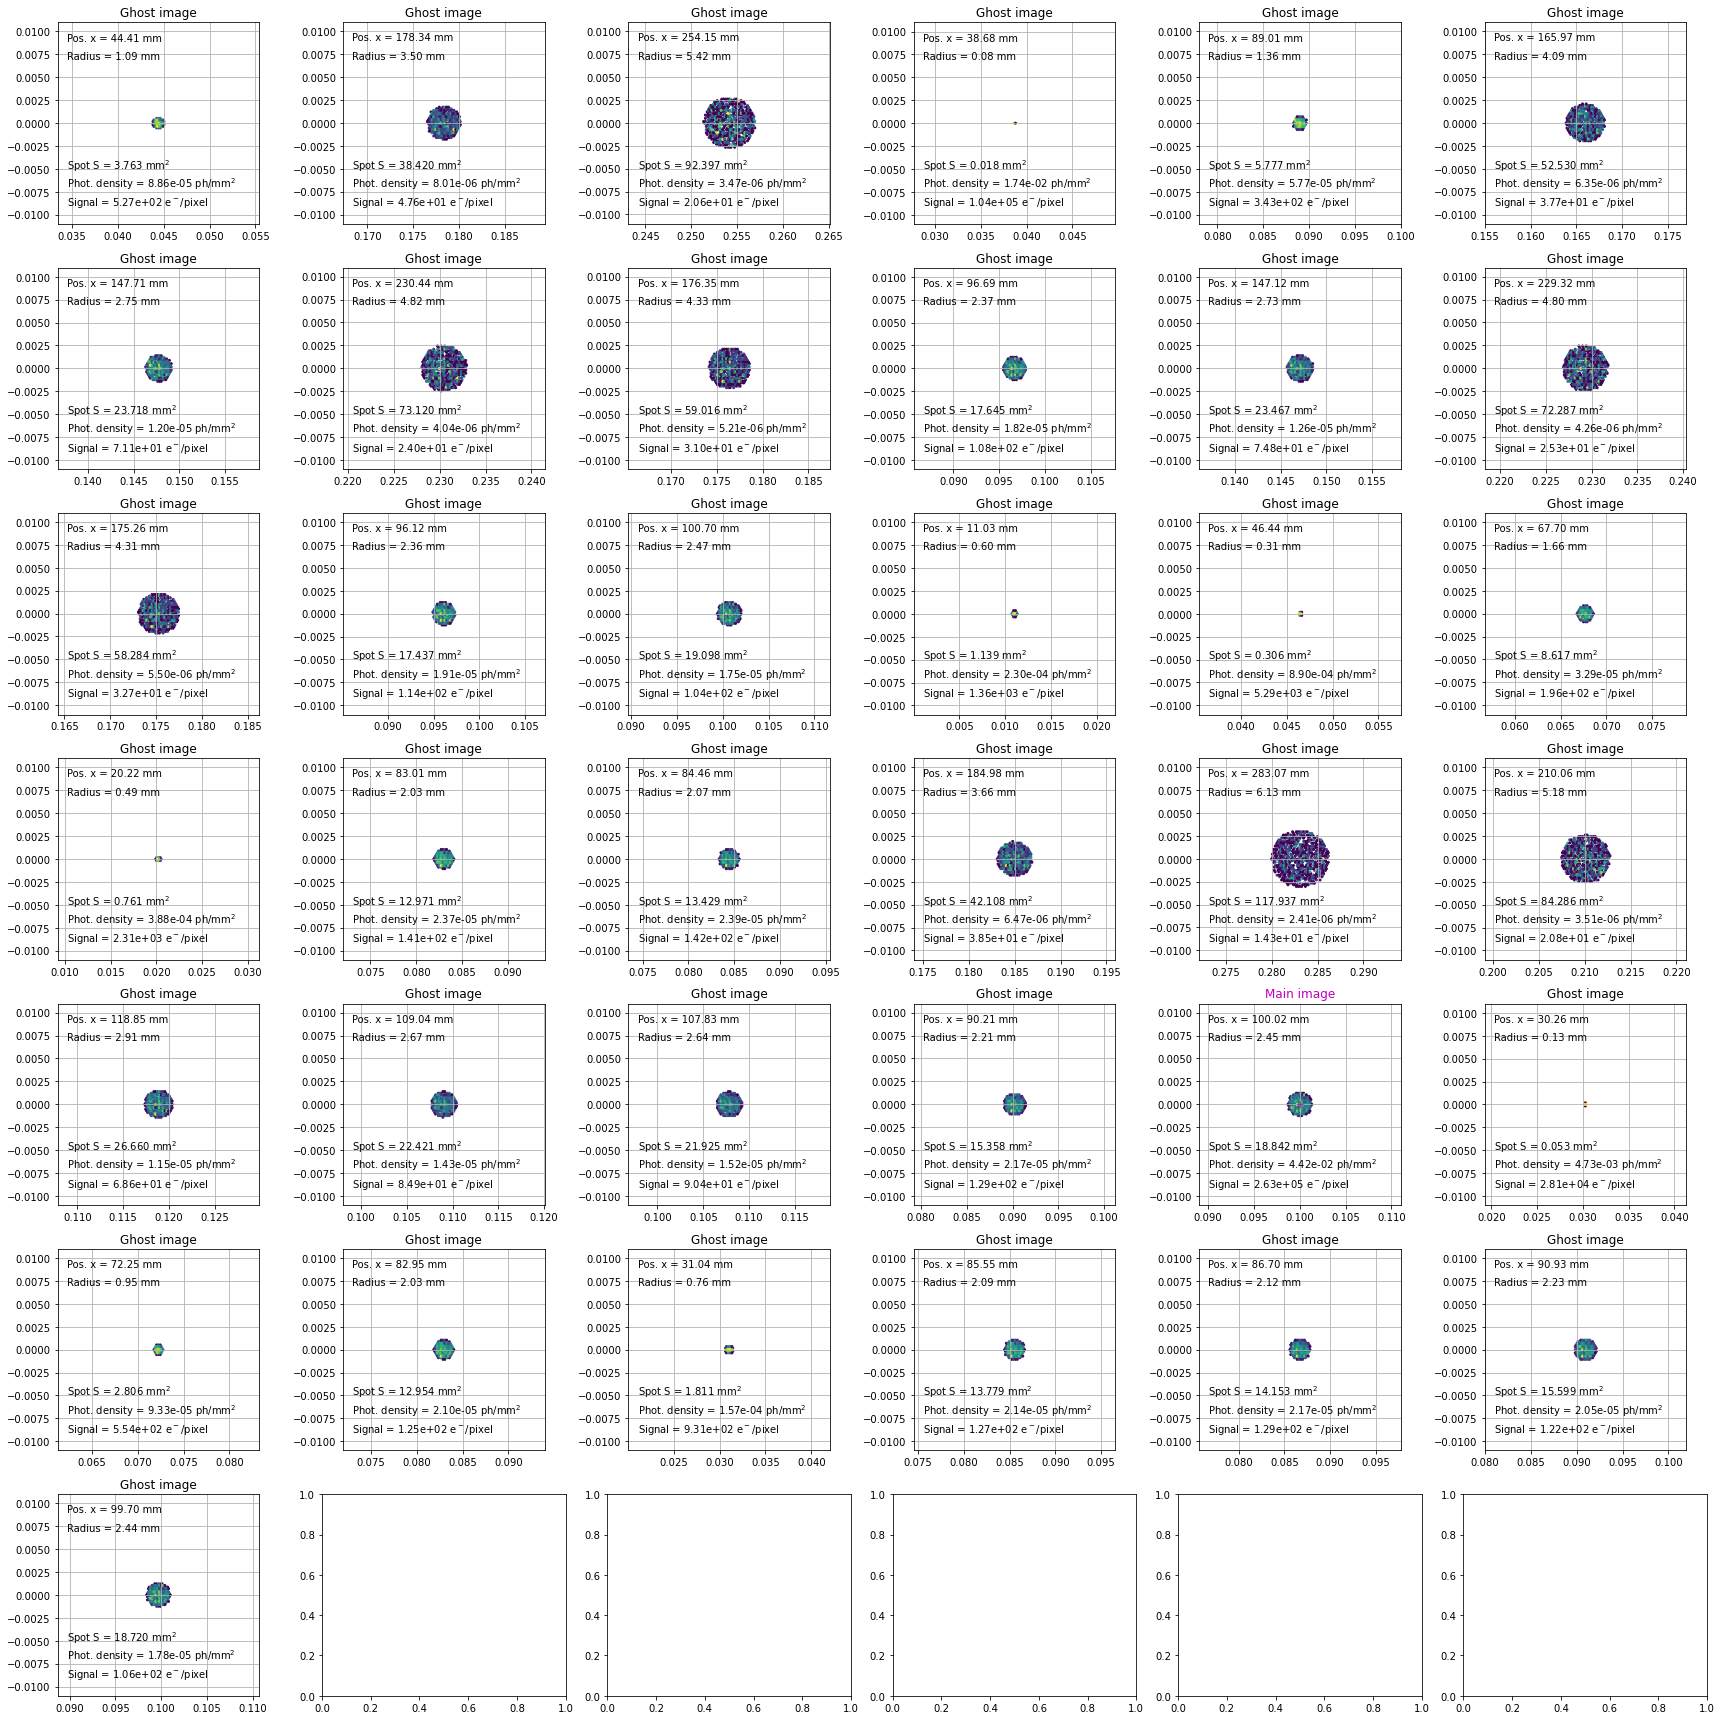

In [10]:
# Run another simulation with rotated L1
rotated_telescope = tweak_optics.rotate_optic(telescope, 'L1', axis='y', angle=1)
tweak_optics.make_optics_reflective(rotated_telescope)

traceFull_2, rForward_2, rReverse_2, rays_2 = simulator.run_simulation(rotated_telescope,
                                                                       beam_config=BEAM_CONFIG_1)
plt.rcParams["figure.figsize"] = [24, 24]
spots_data_2 = plotter.plot_ghosts_map(rForward_2)


In [11]:
data_frame_2 = make_data_frame(spots_data_2, BEAM_CONFIG_1['beam_id'])
data_frame_2.sort_values(by=['name'])

,beam_id,geom_id,index,name,pos_x,std_x,pos_y,std_y,width_x,width_y,radius,radius_err,flux,surface,pixel_signal
33,1,0,33,"(Detector, Filter_entrance)",0.085546,0.000522,-1.283629e-05,0.000522,0.002103,0.002085,0.002094,0.000009,0.295428,13.778602,127.425305
34,1,0,34,"(Detector, Filter_exit)",0.086701,0.000529,-1.300940e-05,0.000529,0.002131,0.002114,0.002123,0.000009,0.307609,14.153250,129.167278
29,1,0,29,"(Detector, L1_entrance)",0.030259,0.000033,7.806380e-07,0.000033,0.000133,0.000127,0.000130,0.000003,0.251339,0.053097,28131.741859
30,1,0,30,"(Detector, L1_exit)",0.072247,0.000235,-5.803351e-06,0.000235,0.000947,0.000943,0.000945,0.000002,0.261702,2.805723,554.335189
31,1,0,31,"(Detector, L2_entrance)",0.082950,0.000506,-1.245331e-05,0.000506,0.002038,0.002023,0.002031,0.000007,0.272493,12.953994,125.014797
32,1,0,32,"(Detector, L2_exit)",0.031038,0.000189,-4.662335e-06,0.000189,0.000761,0.000758,0.000759,0.000002,0.283729,1.810526,931.340064
35,1,0,35,"(Detector, L3_entrance)",0.090931,0.000556,-1.364337e-05,0.000556,0.002240,0.002217,0.002228,0.000012,0.320293,15.598702,122.030406
36,1,0,36,"(Detector, L3_exit)",0.099699,0.000609,-1.495827e-05,0.000609,0.002452,0.002430,0.002441,0.000011,0.333499,18.720234,105.874920
10,1,0,10,"(Filter_entrance, L1_entrance)",0.147117,0.000681,-1.676364e-05,0.000681,0.002743,0.002724,0.002733,0.000010,0.295428,23.466580,74.818849
11,1,0,11,"(Filter_entrance, L1_exit)",0.229317,0.001198,-2.934898e-05,0.001198,0.004825,0.004768,0.004797,0.000029,0.307609,72.286964,25.289992


In [12]:
match_1_2 = match_ghosts(data_frame_1, data_frame_2)
match_1_2

,beam_id_1,geom_id_1,beam_id_2,geom_id_2,ghost_1,ghost_2_2d,distance_2d,distance_2d_err,ghost_2_3d,distance_3d,distance_3d_err
0,1,0,1,0,0,0,0.000184,0.000553,0,0.000937,0.000672
1,1,0,1,0,1,10,0.005046,0.001586,1,0.036311,0.002196
2,1,0,1,0,2,23,0.008093,0.002677,23,0.024371,0.006595
3,1,0,1,0,3,15,0.007851,0.000215,29,0.027625,0.000459
4,1,0,1,0,4,16,0.008748,0.000502,0,0.029171,0.000732
5,1,0,1,0,5,5,0.000897,0.002075,5,0.002113,0.005508
6,1,0,1,0,6,25,0.002775,0.001369,25,0.009883,0.001927
7,1,0,1,0,7,21,0.010161,0.002159,11,0.034303,0.003752
8,1,0,1,0,8,12,0.000193,0.002187,8,0.002226,0.004395
9,1,0,1,0,9,13,0.000091,0.001193,9,0.001225,0.001739


In [13]:
compute_reduced_distance(match_1_2)

0.002935718555761269

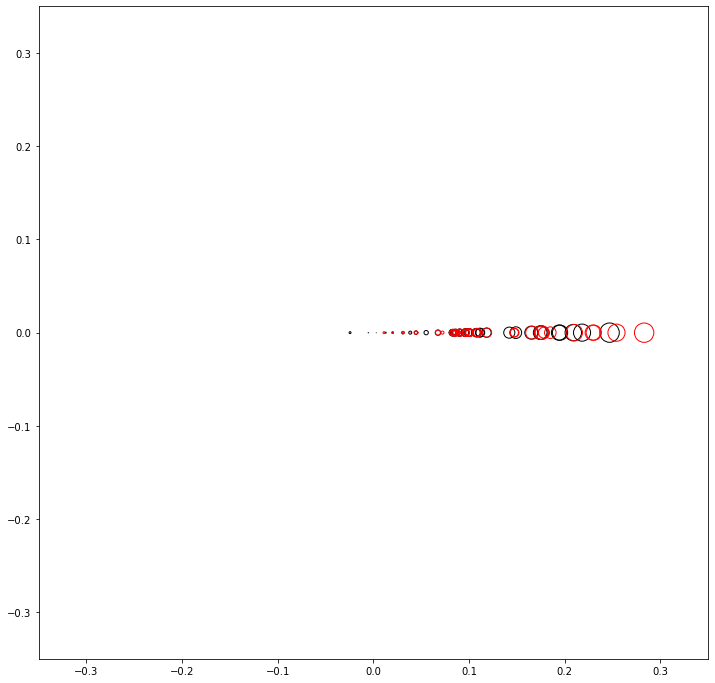

In [14]:
fig, ax = plotter.plot_spots([data_frame_1, data_frame_2])

In [15]:
# See what happens with a random telescope
data_frame_r, ghost_separations_r = simulator.full_random_telescope_sim(telescope,\
                                    max_angle=1, max_shift=0.001, beam_config=BEAM_CONFIG_1)


distance 3d = 0.00409
distance 2d = 0.00262


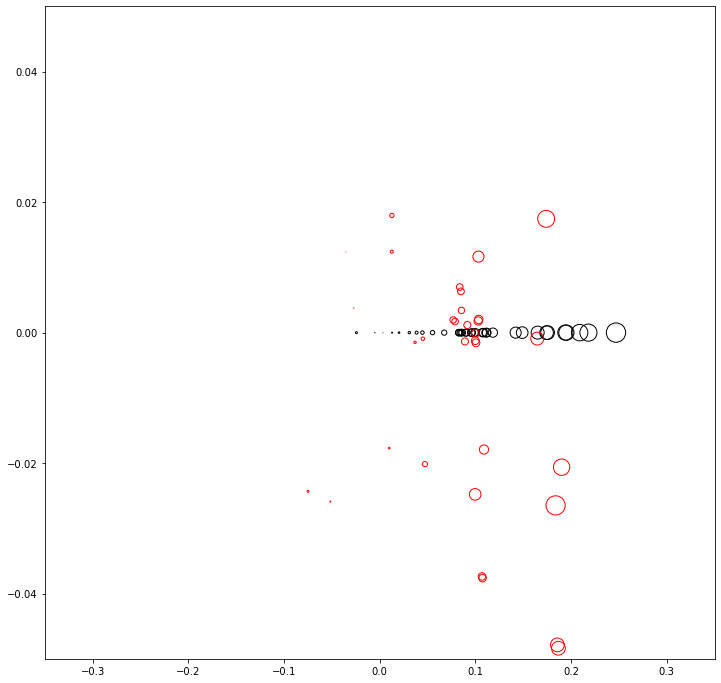

In [16]:
match_1_r = match_ghosts(data_frame_1, data_frame_r)
dist_1_r = compute_reduced_distance(match_1_r)
print(f'distance 3d = {dist_1_r:.5f}')
dist_1_r_2d = compute_2d_reduced_distance(match_1_r)
print(f'distance 2d = {dist_1_r_2d:.5f}')
fig, ax = plotter.plot_spots([data_frame_1, data_frame_r], range_y=(-0.05, 0.05))


In [17]:
# See what happens with a random telescope
data_frame_r2, ghost_separations_r2 = simulator.full_random_telescope_sim(telescope,\
                                    max_angle=1, max_shift=0.001, beam_config=BEAM_CONFIG_1)


distance = 0.00569


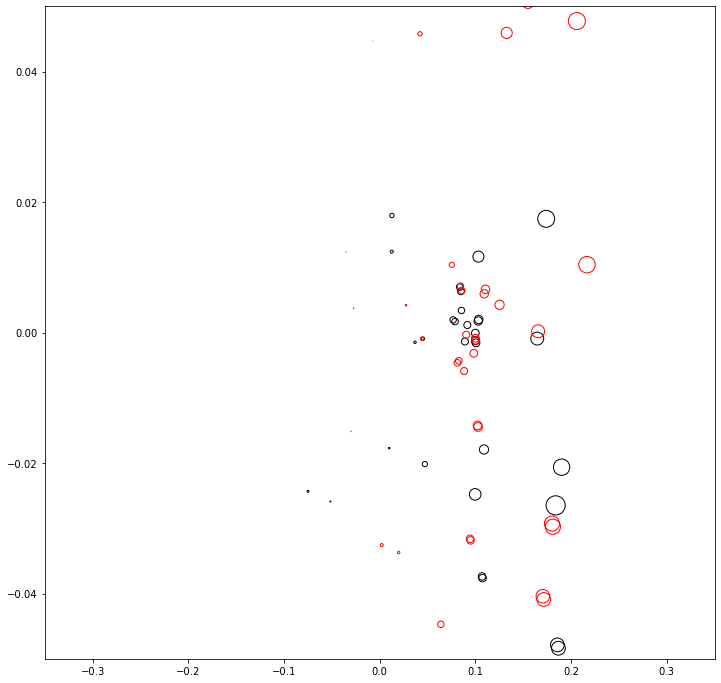

In [18]:
match_r_r2 = match_ghosts(data_frame_r, data_frame_r2)
dist_r_r2 = compute_reduced_distance(match_r_r2)
print(f'distance = {dist_r_r2:.5f}')
fig, ax = plotter.plot_spots([data_frame_r, data_frame_r2], range_y=(-0.05, 0.05))


In [19]:
match_r_r2

,beam_id_1,geom_id_1,beam_id_2,geom_id_2,ghost_1,ghost_2_2d,distance_2d,distance_2d_err,ghost_2_3d,distance_3d,distance_3d_err
0,0,0,0,0,0,0,0.000775,0.000551,0,0.000943,0.000671
1,0,0,0,0,1,26,0.008318,0.001550,1,0.045252,0.002260
2,0,0,0,0,2,5,0.019189,0.002382,2,0.044271,0.003073
3,0,0,0,0,3,29,0.028082,0.000057,29,0.028951,0.000876
4,0,0,0,0,4,18,0.020192,0.000510,4,0.040460,0.000846
5,0,0,0,0,5,5,0.001438,0.002054,5,0.001448,0.002685
6,0,0,0,0,6,9,0.029294,0.001287,6,0.046542,0.001775
7,0,0,0,0,7,8,0.034813,0.002288,7,0.044481,0.003520
8,0,0,0,0,8,8,0.017055,0.002180,8,0.017153,0.002743
9,0,0,0,0,9,9,0.013834,0.001186,9,0.013835,0.001536


In [20]:
distances_2d = list()
distances_3d = list()
for i in range(10):
    df_i, gs_i = simulator.full_random_telescope_sim(telescope,\
                         max_angle=1, max_shift=0.001, beam_config=FAST_BEAM_CONFIG_1)
    match_i = match_ghosts(data_frame_1, df_i)
    dist_i = compute_reduced_distance(match_i)
    distances_3d.append(dist_i)
    
    match_i2 = match_ghosts(data_frame_1, df_i)
    dist_i2 = compute_2d_reduced_distance(match_i2)
    distances_2d.append(dist_i2)


(array([1., 0., 3., 0., 1., 1., 1., 1., 1., 1.]),
 array([0.00153086, 0.00165291, 0.00177497, 0.00189702, 0.00201908,
        0.00214114, 0.00226319, 0.00238525, 0.0025073 , 0.00262936,
        0.00275142]),
 <BarContainer object of 10 artists>)

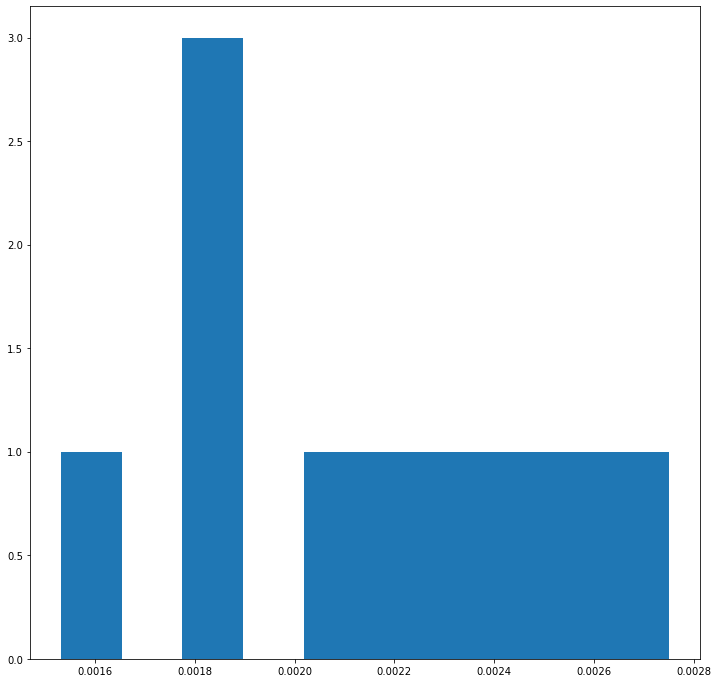

In [21]:
plt.hist(distances_2d)
# plt.xlim(0., 0.010)

(array([1., 1., 1., 4., 1., 0., 0., 1., 0., 1.]),
 array([0.00608637, 0.00709252, 0.00809866, 0.00910481, 0.01011096,
        0.0111171 , 0.01212325, 0.0131294 , 0.01413554, 0.01514169,
        0.01614784]),
 <BarContainer object of 10 artists>)

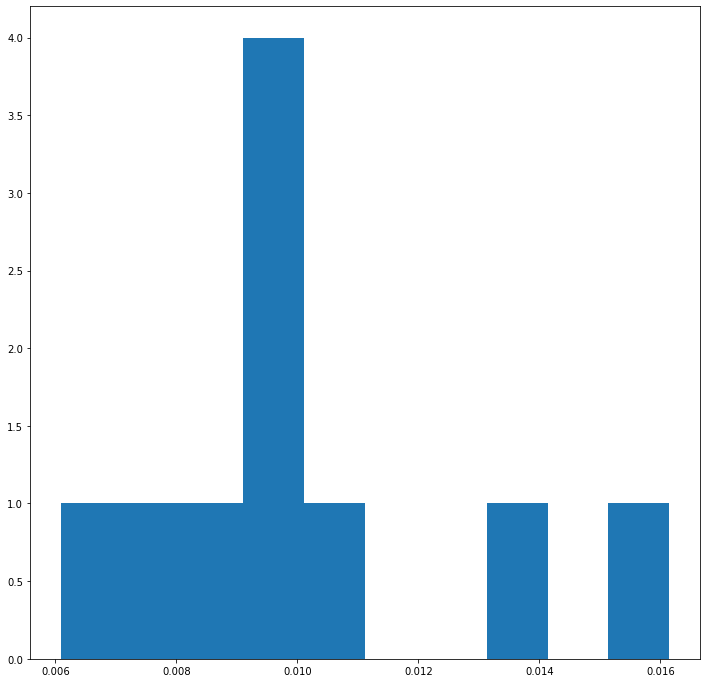

In [22]:
plt.hist(distances_3d)
